In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import optuna
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb



train_data=pd.read_csv('/kaggle/input/playground-series-s3e25/train.csv')
test_data=pd.read_csv('/kaggle/input/playground-series-s3e25/test.csv')

In [2]:
train_data.head()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


Видаляємо стовпчик id

In [3]:
train_data.drop(columns=['id'], inplace=True)

In [4]:
train_data.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


In [5]:
train_data['Hardness'].describe()

count    10407.000000
mean         4.647126
std          1.680525
min          1.000000
25%          3.000000
50%          5.500000
75%          6.000000
max         10.000000
Name: Hardness, dtype: float64

Поділ даних

In [6]:
y = train_data['Hardness']
X = train_data.drop(columns='Hardness')

train, val та test data

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  train_size=0.75,
                                                  random_state=42)

print(f'Train: {X_train.shape[0]} samples \t {round(X_train.shape[0] / X.shape[0] * 100)}%')
print(f'Test:  {X_test.shape[0]} samples \t {round(X_test.shape[0] / X.shape[0] * 100)}%')
print(f'Val:   {X_val.shape[0]} samples \t {round(X_val.shape[0] / X.shape[0] * 100)}%')

Train: 6243 samples 	 60%
Test:  2082 samples 	 20%
Val:   2082 samples 	 20%


In [8]:
num_columns = X.select_dtypes(include="number").columns
cat_columns = X.select_dtypes(include="object").columns

num_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))]
    )

cat_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ("encoder", OneHotEncoder(sparse_output=False))])


preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_columns),
        ("cat", cat_transformer, cat_columns),
    ]
)

preprocessor.set_output(transform='pandas')
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['allelectrons_Total', 'density_Total', 'allelectrons_Average',
       'val_e_Average', 'atomicweight_Average', 'ionenergy_Average',
       'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average',
       'zaratio_Average', 'density_Average'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(sparse_output=False))]),
                                 Index([], dtype='object'))])

Оброблюємо дані за допомогою препроцесора

In [9]:
X_train = preprocessor.fit_transform(X_train)

X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

Створюємо функцію objective та підібрати гіперпараметри

In [10]:
from sklearn import metrics


def objective(trial):

  params = {
        "objective": "mse",
        "verbosity": -1,
        "n_estimators": 30,
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0, log=True),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
  }

  model = lgb.LGBMRegressor(**params)

  model.fit(X_train, y_train)


  y_pred = model.predict(X_val)
  r2 = metrics.r2_score(y_val, y_pred)

  return r2

In [11]:
optuna.logging.set_verbosity(optuna.logging.WARNING) 

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

In [12]:
print(f"найкраща метрика: {study.best_value}")

найкраща метрика: 0.47919656134715616


In [13]:
best_params = study.best_params

model = lgb.LGBMRegressor(**best_params,
                          verbose=-1)

model.fit(X_train, y_train,
          eval_set=[(X_test, y_test), (X_train, y_train)],
          eval_metric='mae')

LGBMRegressor(bagging_fraction=0.9894204711883473, bagging_freq=3,
              feature_fraction=0.4742450508062642,
              lambda_l1=5.50110287968988e-06, lambda_l2=1.1018580564895892e-07,
              learning_rate=0.09833796653104156, min_child_samples=23,
              num_leaves=251, verbose=-1)

In [14]:
def get_metrics(y_true, y_pred, name="model"):
  train_data = pd.DataFrame()

  train_data.loc["MAE", name] = metrics.mean_absolute_error(y_true, y_pred)
  train_data.loc["RMSE", name] = metrics.mean_squared_error(y_true, y_pred) ** 0.5
  train_data.loc["R2", name] = metrics.r2_score(y_true, y_pred)

  return train_data.round(2)

In [15]:
all_metrics = pd.DataFrame()

all_metrics["train"] = get_metrics(y_train, model.predict(X_train))
all_metrics["test"] = get_metrics(y_test, model.predict(X_test))

all_metrics

,train,test
MAE,0.38,0.91
RMSE,0.53,1.22
R2,0.90,0.45


In [16]:
optuna.visualization.plot_param_importances(study)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l1'>

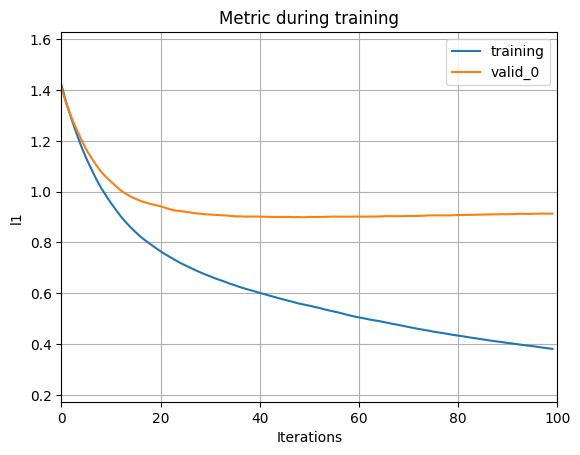

In [17]:
import lightgbm as lgb
lgb.plot_metric(model,
                metric='l1')

In [18]:
model = Pipeline(
    [("prep", preprocessor),
     ("model", model)
     ]
)

model

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['allelectrons_Total', 'density_Total', 'allelectrons_Average',
       'val_e_Average', 'atomicweight_Average', 'ionenergy_Average',
       'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average',
       'zaratio_Average', 'density_Av...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  Index([], dtype='object'))])),
                ('model',
                 LGBMRegressor(bagging_fraction=0.9894204711883473,
                               bagging_freq=3,
                               feature_fraction=0.4742450508062642,
                               lambda_l1=5.50110287968988e-06,
                               lambda_l2=1.1018580564895892e-07,
                               learning_rate=0.09833796653104156,
                               min_child_samples=23, num_leaves=251,
                               verbose=-1))])

In [19]:
def objective(trial):
  params = {
        "objective": "mse",
        "verbosity": -1,
        "n_estimators": 30,
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0, log=True),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
  }

  model = lgb.LGBMRegressor(**params)

  model.fit(X_train, y_train)

  y_pred = model.predict(X_val)

  r2 = metrics.r2_score(y_val, y_pred)
  mae = metrics.mean_absolute_error(y_val, y_pred)
  rmse = metrics.mean_squared_error(y_val, y_pred) ** 0.5



  return r2, mae, rmse

In [20]:
study = optuna.create_study(directions=['maximize', 'minimize', 'minimize'])
study.optimize(objective, n_trials=100)

In [21]:
len(study.best_trials)

2

In [22]:
data = pd.DataFrame([trial.values for trial in study.best_trials],
                    columns=['r2', 'mae', 'rmse'])

data

,r2,mae,rmse
0,0.467235,0.907449,1.230576
1,0.459459,0.902930,1.239524


In [23]:
best_params = study.best_trials[0].params

In [24]:
best_params

{'boosting_type': 'gbdt',
 'learning_rate': 0.14141496436102505,
 'lambda_l1': 3.816328615845158e-06,
 'lambda_l2': 0.2731026733580343,
 'num_leaves': 204,
 'feature_fraction': 0.4379845822635595,
 'bagging_fraction': 0.805627942086101,
 'bagging_freq': 5,
 'min_child_samples': 43}

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42)

In [26]:
from sklearn.model_selection import KFold


def objective(trial):

  params = {
        "objective": "mse",
        "verbosity": -1,
        "n_estimators": 30,
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0, log=True),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
  }


  model = lgb.LGBMRegressor(**params)


  kf = KFold(n_splits=5, shuffle=True, random_state=42)

  r2 = []

  for train_index, test_index in kf.split(X_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    model.fit(X_train_fold, y_train_fold)


    y_pred = model.predict(X_test_fold)

    r2.append(metrics.r2_score(y_test_fold, y_pred))


  return np.mean(r2)

In [27]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

In [28]:
study.best_value

0.44808433224073